Introduction to Quantum errors on Qiskit
========================================

Source:Introduction to Quantum Error Correction using Repetition Codes
[https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html]

This is a "pipe-cleaning" exercise for an MSc Masters project to check that there are no issues with using the IBM Quantum experience.

Calculation of probabilities
--------------------------------------

In [1]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('Probability of a single reply being garbled: {}'.format(p1))
print('Probability of a the majority of three replies being garbled: {:.4f}'.format(p3))

Probability of a single reply being garbled: 0.01
Probability of a the majority of three replies being garbled: 0.0003


Noise model
-----------

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [3]:
noise_model = get_noise(0.01,0.01)

Call the function with 1% error for each type of noise.

In [4]:
noise_model = get_noise(0.01,0.01)

Now simulate a quantum circuit with noise of 1%.

The different states |000> etc can be counted.  The simulated result is {'000': 1001, '001': 9, '010': 9, '100': 5}


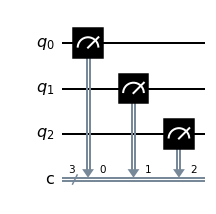

In [5]:
from qiskit import QuantumCircuit, execute, Aer
qc0 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state
qc0.measure(qc0.qregs[0],qc0.cregs[0]) # measure the qubits
# run the circuit with th noise model and extract the counts
counts = execute( qc0, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
print ('The different states |000> etc can be counted.  The simulated result is', counts)
qc0.draw(output='mpl')

Even though there is noise the state |000> dosen't change much.  Now look at a more complicated example with parity checking of syndrome bits:

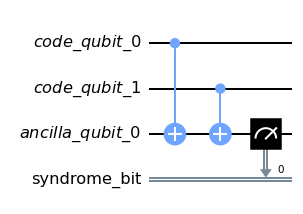

In [6]:
from qiskit import QuantumRegister, ClassicalRegister
cq = QuantumRegister(2,'code_qubit')     # Two code QBits
lq = QuantumRegister(1,'ancilla_qubit')  # One Ancilla bit
sb = ClassicalRegister(1,'syndrome_bit') # One Syndrome bit
qc = QuantumCircuit(cq,lq,sb)
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.measure(lq,sb)
qc.draw()
#initialise circuit
qc_init = QuantumCircuit(cq)
(qc_init+qc).draw(output='mpl')

In [7]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


The results above are always 0 for the |00> QBit input from initialisation.

Moving on, we now import the necessary tools from Ingis.
  Repetition Code sets up the gates for the Repetition code.
    These are decoded with either:
        Look up table decoding
        Graph decoder

In [8]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

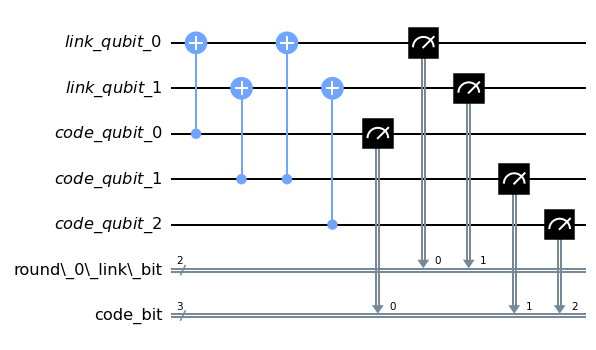

In [9]:
n = 3
T = 1
code = RepetitionCode(n,T)
code.circuit['0'].draw(output='mpl')

Run in a simulator without any noise. Note results are shown as {'physical bits eg |000 syndrome measurement eg 00: count eg 1024.

In [10]:
def get_raw_results(code,noise_model=None):

    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



Now add noise.

In [11]:
code = RepetitionCode(3,1)
noise_model = get_noise(0.05,0.05)
raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00': 674, '000 01': 59, '100 00': 59, '100 01': 4, '100 10': 7, '101 00': 2, '101 01': 1, '101 10': 1, '110 00': 3, '000 10': 67, '000 11': 1, '001 00': 44, '001 01': 7, '001 10': 5, '010 00': 49, '010 01': 32, '010 10': 4, '010 11': 1, '011 00': 2, '011 01': 2} 

Logical 1 : {'100 00': 6, '100 01': 2, '100 10': 1, '100 11': 1, '101 00': 43, '101 01': 22, '101 10': 2, '101 11': 18, '110 00': 58, '110 01': 29, '110 10': 3, '110 11': 1, '111 00': 604, '111 01': 60, '111 10': 54, '111 11': 15, '001 00': 6, '001 01': 1, '001 10': 4, '001 11': 1, '010 00': 2, '010 01': 1, '010 10': 2, '010 11': 2, '011 00': 57, '011 01': 4, '011 10': 20, '011 11': 5} 



Error correction based on syndrome calculation

In [12]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000 )
    table_results[str(log)] = job.result().get_counts(str(log))

Calculate P, the probability of error, based on using a look up table from the results above.

In [13]:
P = lookuptable_decoding(raw_results,table_results)
print('P =',P)

P = {'0': 0.0233, '1': 0.0219}


In [14]:
code = RepetitionCode(3,2)
raw_results = get_raw_results(code,noise_model)
results = code.process_results( raw_results )
for log in ['0','1']:
    print('\nLogical ' + log + ':')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=50 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=50 })


Logical 0:
raw results        {'000 00 00': 486, '000 00 01': 55, '000 00 10': 51, '000 01 00': 54, '000 10 00': 52}
processed results  {'0 0  00 00 00': 486, '0 0  01 01 00': 55, '0 0  10 10 00': 51, '0 0  00 01 01': 54, '0 0  00 10 10': 52}

Logical 1:
raw results        {'111 00 00': 471, '111 00 01': 58, '111 10 00': 52}
processed results  {'1 1  00 00 00': 471, '1 1  01 01 00': 58, '1 1  00 10 10': 52}


'000 00 00' has been transformed to '0 0 00 00 00', and '111 00 00' to '1 1 00 00 00', and so on.
Real example set step_2 and step_3 to True when ready to run

In [15]:
step_2 = False 
step_3 = False

In [16]:
from qiskit import IBMQ
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

In [17]:
device_name = 'ibmq_16_melbourne'
if step_2:
    IBMQ.load_account()
    for provider in IBMQ.providers():
        for potential_backend in provider.backends():
            if potential_backend.name()==device_name:
                backend = potential_backend
    coupling_map = backend.configuration().coupling_map

Set up specific data for IBM Melbourne computer

In [18]:
if device_name=='ibmq_16_melbourne':
    line = [13,14,0,1,2,12,11,3,4,10,9,5,6,8,7]

Create repetition code

In [19]:
n_min = 3
n_max = int((len(line)+1)/2)
code = {}
for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

Tell transpiler which physical links to use.

In [20]:
def get_initial_layout(code,line):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

Transpile QBits

In [21]:
if step_2:
    circuits = []
    for n in range(n_min,n_max+1):
        initial_layout = get_initial_layout(code[n],line)
        for log in ['0','1']:
            circuits.append( transpile(code[n].circuit[log], backend=backend, initial_layout=initial_layout) )
            num_cx = dict(circuits[-1].count_ops())['cx']
            assert num_cx==2*(n-1), str(num_cx) + ' instead of ' + str(2*(n-1)) + ' cx gates for n = ' + str(n)

Ready to run job

In [22]:
if step_2:
    job = execute(circuits,backend,shots=8192)
    raw_results = {}
    j = 0
    for d in range(n_min,n_max+1):
        raw_results[d] = {}
        for log in ['0','1']:
            raw_results[d][log] = job.result().get_counts(j)
            j += 1

Now decoding:

In [23]:
if step_3:
    results = {}
    for n in range(n_min,n_max+1):
        results[n] = code[n].process_results( raw_results[n] )

In [24]:
if step_3:
    dec = {}
    for n in range(n_min,n_max+1):
        dec[n] = GraphDecoder(code[n])

In [25]:
if step_3:
    logical_prob_match = {}
    for n in range(n_min,n_max+1):
        logical_prob_match[n] = dec[n].get_logical_prob(results[n])
    with open('./logical_prob_match_'+device_name+'.txt', 'w') as file:
        file.write(str(logical_prob_match))
else:
    with open('./logical_prob_match_'+device_name+'.txt', 'r') as file:
        logical_prob_match = eval(file.read())

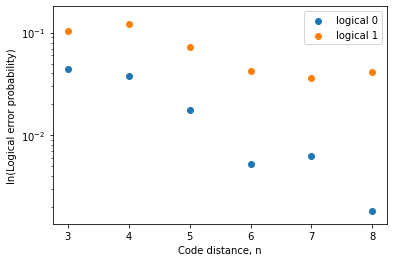

In [26]:
import matplotlib.pyplot as plt
import numpy as np

x_axis = range(n_min,n_max+1)
P = { log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1'] }

ax = plt.gca()
plt.xlabel('Code distance, n')
plt.ylabel('ln(Logical error probability)')
ax.scatter( x_axis, P['0'], label="logical 0")
ax.scatter( x_axis, P['1'], label="logical 1")
ax.set_yscale('log')
ax.set_ylim(ymax=1.5*max(P['0']+P['1']),ymin=0.75*min(P['0']+P['1']))
plt.legend()

plt.show()